[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/susannaruecker/NLP-workshop/blob/main/02_Word-Embeddings_FFN_RNN_fastText.ipynb)

In [1]:
import pandas as pd
import numpy as np
import nltk # a very handy NLP library (for simple but annoying things such as tokenization, stopwords, lemmatization) (also: spacy)
nltk.download('punkt')
!pip install wget
import os, gzip, wget, zipfile

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9672 sha256=86c903a528e12890dde4c6475a89182b264ba7e3db5996b23e7ffa1a0bfbbbad
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget


# What we will do here:

* instead of BOW we want to use Word Embeddings now
* representing a token as a vector
* vectors capture meaning (similar words get similar vectors)
* main usages of Word Embeddings:
    * in form of (randomly initialized) embedding layers in model architectures
    * or making use of **pretrained** Embeddings that already encode meaning as features (e.g. average the word embeddings of all tokens --> centroid/"bag-of-vectors" as input for a FFN)
    * or both: initialize embedding layers with weights from pretrained embeddings --> text as a sequence of vectors as input for  RNNs, (CNNs), Transformers

* several different approaches are in this notebook (hopefully not too confusing...) 

* you will find some ugly helper functions, ignore them more or less... (loading embeddings, averaging them, ...)

* we will use the pretrained fastText embeddings here (not that modern or "up to date", but exist for several languages), of course there are others (GloVe, ELMO, ...)


#### Helper function for downloading the German fastText vectors

(maybe not the prettiest way to do things...)

In [2]:
def load_fasttext_vectors(iso = "de", limit=None, target_path = 'fasttext/'):

    if not os.path.exists(target_path):
        print(f"creating folder {target_path}")
        os.makedirs(target_path)

    # if necessary download (german) fastText Embeddings
    url = f'https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.{iso}.300.vec.gz'

    
    target_path = target_path + f'{iso}'
    print(target_path)
    if not os.path.isfile(target_path):
        print('downloading vectors...')
        wget.download(url, out=target_path)
        print('done')
    else:
        print('file already exists')

    print('loading embeddings ...')

    f = gzip.open(target_path, 'rb')
    n, d = map(int, f.readline().split())
    data = {}
    counter = 0
    for line in f:
        line = line.decode()
        tokens = line.rstrip().split(' ')
        data[tokens[0]] = np.array(tokens[1:], dtype=np.float32)
        counter += 1
        if limit:
          if counter >= limit:
                break
    if limit:
        print(f"done loading embs WITH LIMIT {str(limit)}")
    else:
        print('done loading embs FULL')
    
    f.close()
    
    return data

In [3]:
# this will take some time...
embs = load_fasttext_vectors(iso = "de", limit=100000) # fastText file ist sorted by (decreasing) frequency, so for time reasons we only take the first N lines/words

creating folder fasttext/
fasttext/de
downloading vectors...
done
loading embeddings ...
done loading embs WITH LIMIT 100000


In [4]:
type(embs), len(embs) # here: a dictionary

(dict, 100000)

### Play around with fastText embeddings

In [5]:
embs.get("die")[:20] # makes sense, right? ;)

array([-0.0084,  0.0161,  0.1399, -0.0382, -0.0042,  0.2651,  0.0373,
        0.0522,  0.01  , -0.1401, -0.0171, -0.0086, -0.0979, -0.0401,
        0.012 , -0.0017, -0.0058, -0.0146,  0.0207, -0.0009],
      dtype=float32)

In [6]:
print(embs.get("die").shape) # 300 dimensions
embs_vocab = list(embs.keys())
print(len(embs_vocab)) # nr of known/used tokens
print(embs_vocab[:50]) # some of them (file is sorted by frequency, don't be confused!)

(300,)
100000
[',', '.', '</s>', 'und', 'der', ':', 'die', '"', ')', '(', 'in', 'von', 'den', 'mit', 'ist', 'für', 'zu', '/', 'das', 'im', 'auf', 'des', 'ein', 'nicht', 'dem', 'Die', 'eine', 'sich', '-', 'auch', 'als', "'", 'es', 'an', 'Sie', 'bei', 'ich', 'aus', '–', '!', 'er', 'oder', 'wurde', '?', 'sind', 'nach', 'werden', 'am', 'zum', '&']


In [7]:
sample = "Bald ist Weihnachten! Das ist schön."

for t in nltk.word_tokenize(sample):
  print(t, "\t", embs.get(t)[:5])

Bald 	 [ 0.0018  0.1447 -0.085   0.0583  0.0828]
ist 	 [-0.0717  0.0541  0.1029  0.03   -0.0219]
Weihnachten 	 [ 0.0196 -0.0234 -0.0085  0.0172  0.0059]
! 	 [-0.2462 -0.1792 -0.1634 -0.178  -0.0885]
Das 	 [-0.0561  0.0101  0.0784  0.0929  0.0192]
ist 	 [-0.0717  0.0541  0.1029  0.03   -0.0219]
schön 	 [ 0.0037  0.0207  0.0024 -0.0458 -0.0433]
. 	 [-0.0257  0.0093 -0.0562 -0.0464 -0.0113]


In [8]:
from sklearn.metrics.pairwise import cosine_similarity

def similarity(a,b):
    vec1 = embs.get(a)
    vec2 = embs.get(b)
    return cosine_similarity(vec1.reshape(1,-1), vec2.reshape(1,-1)).squeeze()

print(similarity("Hund", "Katze"))
print(similarity("Katze", "Katze"))
print(similarity("Philosophie", "Katze"))
print(similarity("Philosophie", "Kunst"))

0.7219703
1.0
0.25203928
0.53908384


In [9]:
print(similarity("Hund", "hund")) # be careful, nothing is perfect...

0.69624454


# Some things to think about when using pretrained embeddings in real life:
* what language am I dealing with?
* dimensionality?
* vocab size, domain, what were they trained on, when, ...?
* always look into them: preprocessing of embeddings and your text data should be (ideally) as similar as possible (sometimes not that easy...)
    * lemmatization, stemming, lower/capital, puctuation, stopwords...
* check what percentage of tokens are found in your embeddings (sometimes this is less than you would think)

# Back to our text classification task (10kGNAD)

In [10]:
import requests
import os

os.makedirs('10kGNAD', exist_ok=True) # create folder in Colab

# download public 10kGNAD train and test data from github repo

url_train = 'https://raw.githubusercontent.com/tblock/10kGNAD/master/train.csv'
read_train = requests.get(url_train, allow_redirects=True)
open('10kGNAD/train.csv', 'wb').write(read_train.content)

url_test = 'https://raw.githubusercontent.com/tblock/10kGNAD/master/test.csv'
read_test = requests.get(url_test, allow_redirects=True)
open('10kGNAD/test.csv', 'wb').write(read_test.content)

2755020

In [11]:
df_train = pd.read_csv("10kGNAD/train.csv", sep = ';', 
                       encoding = "utf-8", 
                       quotechar='\'', header=None, names = ["label", "article"])

df_test = pd.read_csv("10kGNAD/test.csv", sep = ';', 
                      encoding = "utf-8", 
                      quotechar='\'', header=None, names = ["label", "article"])

In [12]:
# use the LabelEncoder vom scklearn, and save the order/mapping for later
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
label_encoded=le.fit(df_train.label)
print(le.classes_)
label_names = le.classes_

label_to_id = {c: i for (i, c) in enumerate(le.classes_)}
print(label_to_id)

id_to_label = {v: k for k, v in label_to_id.items()}
print(id_to_label)

df_train["label_id"] = df_train.label.map(label_to_id)
df_test["label_id"] = df_test.label.map(label_to_id)

print("\nShapes:", df_train.shape, df_test.shape)

['Etat' 'Inland' 'International' 'Kultur' 'Panorama' 'Sport' 'Web'
 'Wirtschaft' 'Wissenschaft']
{'Etat': 0, 'Inland': 1, 'International': 2, 'Kultur': 3, 'Panorama': 4, 'Sport': 5, 'Web': 6, 'Wirtschaft': 7, 'Wissenschaft': 8}
{0: 'Etat', 1: 'Inland', 2: 'International', 3: 'Kultur', 4: 'Panorama', 5: 'Sport', 6: 'Web', 7: 'Wirtschaft', 8: 'Wissenschaft'}

Shapes: (9245, 3) (1028, 3)


In [13]:
# put the articles in two lists (not really necessary, but simpler for encoding them)
train_texts = df_train.article.values
test_texts = df_test.article.values

print(len(train_texts), len(test_texts))

9245 1028


In [14]:
train_texts[0][:400]

'21-Jähriger fällt wohl bis Saisonende aus. Wien – Rapid muss wohl bis Saisonende auf Offensivspieler Thomas Murg verzichten. Der im Winter aus Ried gekommene 21-Jährige erlitt beim 0:4-Heimdebakel gegen Admira Wacker Mödling am Samstag einen Teilriss des Innenbandes im linken Knie, wie eine Magnetresonanz-Untersuchung am Donnerstag ergab. Murg erhielt eine Schiene, muss aber nicht operiert werden.'

In [15]:
# labels
y_train = df_train.label_id.values
y_test = df_test.label_id.values
print(y_train.shape, y_test.shape)

(9245,) (1028,)


In [16]:
y_train, y_test

(array([5, 3, 6, ..., 7, 1, 4]), array([7, 5, 6, ..., 5, 5, 6]))

## First: Using _centroid_ ("bag of vectors") as input for a FFN

In [17]:
# helper function for getting centroid vector (averaging all vectors)
def get_centroid(text, embs, preprocessor = None, tokenizer= None, embs_dimension = 300, max_len = None):
    """
    centroid means ONE vector per document (= averaging all word vectors)
    returns vector and list of used tokens
    """
    vector = np.zeros(embs_dimension)
    if preprocessor: # if we have a specific preprocessor (dealing with lemmatization, stop words, capital letters, numbers ...)
        text = preprocessor(text)
    
    if tokenizer:
        tokens = tokenizer(text)
    
    else:
        tokens = nltk.word_tokenize(text)
    
    counter = 0
    used_tokens = []
    for n,t in enumerate(tokens):
        if t in embs:
            vector += embs.get(t)
            counter +=1
            used_tokens.append(t)
        if max_len:
            if n > max_len:
                break
    if counter !=0:
        vector = vector/counter
    return vector, used_tokens



In [18]:
EMBEDDING_DIM = 300 # fastText vectors have dimension 300
sample = "Dieser extreeeeem kreative Satz wird als ein Zentroid repräsentiert."
centroid, tokens = get_centroid(sample, embs, embs_dimension = EMBEDDING_DIM)
print(centroid.shape) # centroid vector
print(tokens)         # these words were looked up in embeddings

(300,)
['Dieser', 'kreative', 'Satz', 'wird', 'als', 'ein', 'repräsentiert', '.']


### Creating Features (centroid vectors), using the helper function:

In [19]:
train_centroid = np.array([ get_centroid(t, embs, embs_dimension=EMBEDDING_DIM)[0] for t in train_texts ])
test_centroid = np.array([ get_centroid(t, embs, embs_dimension=EMBEDDING_DIM)[0] for t in test_texts ])

In [20]:
print(train_centroid.shape)
print(test_centroid.shape)

(9245, 300)
(1028, 300)


In [21]:
train_centroid[0][:10] # this is what one text looks like now

array([-0.012875  ,  0.01537344,  0.00363125,  0.03094375,  0.0268375 ,
        0.03983594, -0.01309062,  0.0186375 , -0.00454219, -0.02673906])

### Creating the model, still a simple FFN (one text is one vector, still not a sequence)

In [24]:
import tensorflow as tf

ffn = tf.keras.Sequential([
    tf.keras.Input(shape=(EMBEDDING_DIM,)), # 300 is embedding dimension
    tf.keras.layers.Dropout(.2),
    tf.keras.layers.Dense(64, activation='sigmoid'),
    tf.keras.layers.Dense(9, activation='softmax')
])
ffn.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_2 (Dropout)         (None, 300)               0         
                                                                 
 dense_4 (Dense)             (None, 64)                19264     
                                                                 
 dense_5 (Dense)             (None, 9)                 585       
                                                                 
Total params: 19,849
Trainable params: 19,849
Non-trainable params: 0
_________________________________________________________________


In [25]:
ffn.compile(optimizer='adam',
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy'])

In [26]:
history = ffn.fit(train_centroid, y_train, epochs=80, batch_size=64, verbose=1,
                   validation_data=(test_centroid, y_test))

Epoch 1/80
145/145 [==============================] - 3s 5ms/step - loss: 2.1192 - accuracy: 0.1776 - val_loss: 2.0855 - val_accuracy: 0.2101
Epoch 2/80
145/145 [==============================] - 1s 4ms/step - loss: 2.0675 - accuracy: 0.2687 - val_loss: 2.0439 - val_accuracy: 0.2374
Epoch 3/80
145/145 [==============================] - 1s 4ms/step - loss: 2.0245 - accuracy: 0.3190 - val_loss: 1.9940 - val_accuracy: 0.4329
Epoch 4/80
145/145 [==============================] - 1s 4ms/step - loss: 1.9757 - accuracy: 0.3873 - val_loss: 1.9400 - val_accuracy: 0.3492
Epoch 5/80
145/145 [==============================] - 1s 4ms/step - loss: 1.9228 - accuracy: 0.4172 - val_loss: 1.8816 - val_accuracy: 0.4095
Epoch 6/80
145/145 [==============================] - 1s 4ms/step - loss: 1.8668 - accuracy: 0.4279 - val_loss: 1.8188 - val_accuracy: 0.5078
Epoch 7/80
145/145 [==============================] - 1s 4ms/step - loss: 1.8067 - accuracy: 0.4610 - val_loss: 1.7552 - val_accuracy: 0.4854
Epoch 

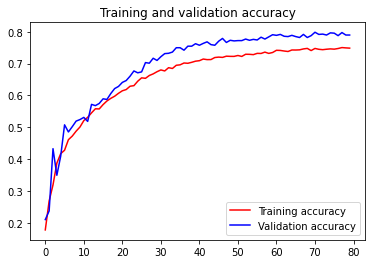

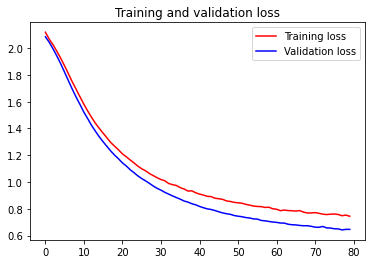

<Figure size 432x288 with 0 Axes>

In [27]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()


plt.show()

### Predicting our new texts

In [28]:
new_texts = [
             """Der Südbadische Fußballverband (SBFV) hat auf die aktuelle Entwicklung in der Corona-Pandemie reagiert. Der Verbandsvorstand beschloss am Abend, mit dem Spielbetrieb in allen 
             südbadischen Alters- und Spielklassen von der Verbandsliga abwärts vorzeitig in die Winterpause zu gehen.""",
             
             """Vor dem Bund-Länder-Gespräch über weitere Einschränkungen und Verbote werden die Forderungen nach einem harten Lockdown lauter. Der Präsident des Städtetages Baden-Württemberg, 
             Mannheims Oberbürgermeister Peter Kurz (SPD), hält ihn für nötig, wenn sich die Corona-Lage in den kommenden Tagen weiter verschärft.
             """,
             
             """Dank einer taktischen Umstellung für die letzten fünf Spielminuten und dem viel zitierten Spielglück haben die Basketballerinnen des USC Freiburg ihren Heimnimbus in dieser Saison gewahrt und sich in der 
             Spitzengruppe der Bundesliga festgekrallt. Am Samstagabend gewannen die Eisvögel im sechsten Spiel in der Unihalle zum sechsten Mal
             """,
             
             """Abgesehen von pandemiegeschuldeter Einlasskontrolle und Maskenpflicht war es wie früher: das Freiburger Konzerthaus – ausverkauft! Kein Wunder, wenn die aus Südbaden stammende Weltklasse-Geigerin 
             Anne-Sophie Mutter und ihre seit nunmehr zehn Jahren bestehenden Mutter’s Virtuosi auftreten. Mittelpunkt und Rahmen jetzt: Antonio Vivaldi.
             """,
             
             """Ja, es ist ein Jugendstück. Anton Tschechow war 18 Jahre alt, als er es schrieb - und wieder vernichtete, nachdem es kein Gehör gefunden hatte. 
             Die Erstschrift hat sich erhalten und wurde 1920 unter dem – nicht von Tschechow stammenden – Titel "Platonow" veröffentlicht. Eine Jugendsünde ist es nicht, 
             denn viele Motive aus dem späteren Werk klingen an. Nur: Wenn man es vom Blatt spielte, dauerte die Aufführung geschlagene sechs Stunden, länger als jede Wagner-Oper. 
             """,

             #
             # feel free to be creative and write your own test arcticle! :)
             #
]

In [29]:
# remeber what you did earlier when creating the features? repeat!
X_centroid = np.array([ get_centroid(t, embs, embs_dimension=EMBEDDING_DIM)[0] for t in new_texts ])

In [31]:
probs = ffn.predict(X_centroid)
#print(probs)
#print("----")

labels = np.argmax(probs,axis=1)
print(labels)
print("----")

print( [ (l, id_to_label[l]) for l in labels]) # looks okay

[5 2 5 3 4]
----
[(5, 'Sport'), (2, 'International'), (5, 'Sport'), (3, 'Kultur'), (4, 'Panorama')]


In [32]:
id_to_label # just to remember what labels we have

{0: 'Etat',
 1: 'Inland',
 2: 'International',
 3: 'Kultur',
 4: 'Panorama',
 5: 'Sport',
 6: 'Web',
 7: 'Wirtschaft',
 8: 'Wissenschaft'}

# ... Done with the first part of the notebook :)

Now we will turn to representing text as a _sequence_ and using RNNs instead.

(We will need the embeddings later on, therefore I didn't start a new notebook...)


---


# Now: RNN, so looking at text as a sequence, not just one vector

* using embedding layer in keras
* first: using them "from scratch" (so without any pretrained weights)
* then: loading weights from your fastText embeddings

### Get padded sequences of token ids from the texts --> turn words into numbers

* we use Keras preprocessing methods
* define vocab size, OOV-token, and fixed length
* tokenize text to id lists (specific mapping is used, take a look at it)
* pad/truncate those lists to same length

In [33]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

VOCAB_SIZE = 10000           # note: to low means a lot of unknown words, to high means potentially very sparse features AND huge size of parameters in embedding layer
OOV_TOKEN = "<OOV>"
FIXED_LEN = 500              # length of sequence, every text gets truncated or padded to this size --> so we can process in batches even though texts have different length

tokenizer = Tokenizer(num_words = VOCAB_SIZE,   # define how many unique words you want to have inyout vocabulary
                      oov_token=OOV_TOKEN,      # define what to assign to out-of-vocabulary tokens
                      lower=False)              # Achtung wichtig, defaults to True, die Embeddings sind aber nicht lower cased, daher für mapping False setzen!

tokenizer.fit_on_texts(train_texts)
word_index = tokenizer.word_index

print(len(word_index)) # this is indeed confusing... the word_index still lists ALL unique words (ignoring num_words), only later on all OOV-tokens get labeled as "OOV" (1)

train_ids = tokenizer.texts_to_sequences(train_texts)                                           # this is a list of id lists of still different sizes
train_padded = pad_sequences(train_ids,maxlen=FIXED_LEN, truncating="post", padding = "post")   # this does the padding/truncating

test_ids = tokenizer.texts_to_sequences(test_texts)
test_padded = pad_sequences(test_ids,maxlen=FIXED_LEN, truncating="post", padding = "post")


189019


In [34]:
print(len(train_ids[0])) # first text
print(len(train_ids[1])) # second text, note the different lengths
print(len(train_ids[2]))

68
587
289


In [35]:
print(train_padded.shape, test_padded.shape) # now all are padded/truncated so we can use them in batches!

(9245, 500) (1028, 500)


In [36]:
train_texts[0] # one original text...

'21-Jähriger fällt wohl bis Saisonende aus. Wien – Rapid muss wohl bis Saisonende auf Offensivspieler Thomas Murg verzichten. Der im Winter aus Ried gekommene 21-Jährige erlitt beim 0:4-Heimdebakel gegen Admira Wacker Mödling am Samstag einen Teilriss des Innenbandes im linken Knie, wie eine Magnetresonanz-Untersuchung am Donnerstag ergab. Murg erhielt eine Schiene, muss aber nicht operiert werden. Dennoch steht ihm eine mehrwöchige Pause bevor.'

In [37]:
#train_ids[0] # ... went from this ...

In [39]:
train_padded[0] # ...to this! (this one is short, most are longer!)

# 1 is id for "OOV" so token that is unknown to the tokenizer (play around with VOCAB_SIZE to get more/les 1's)
# 0 is reserved for padding

array([ 415, 2561, 1292,  304,   65, 7211,   31,   69,   17,  606,  128,
        304,   65, 7211,   11,    1,  687,    1, 2328,   33,   12, 1371,
         31, 2279,    1,  415,  341, 4250,  122,  112,  135,    1,   59,
       1546, 3421, 5352,   27,  312,   46,    1,   22,    1,   12, 2187,
       3525,   39,   23,    1, 1334,   27,  240, 4468,    1, 2007,   23,
          1,  128,   43,   15, 8476,   29, 1726,  216,  220,   23,    1,
       1527, 1033,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

#### Just getting a bit more confortable with what we're dealing with (tokenizer vocab, mapping between tokens and ids):

In [44]:
# look at some tokens and their ids in the tokenizer vocab
# good to know: starts with 1 ("OOV"), then normal tokens
for n, (w,i) in enumerate(tokenizer.word_index.items()):
    print(w, "\t", i)
    if n >= 20:
        break

<OOV> 	 1
der 	 2
die 	 3
und 	 4
in 	 5
den 	 6
von 	 7
zu 	 8
mit 	 9
das 	 10
auf 	 11
im 	 12
ist 	 13
für 	 14
nicht 	 15
sich 	 16
– 	 17
Die 	 18
ein 	 19
dem 	 20
es 	 21


In [45]:
# other way around, might be useful later
id_to_token = {v: k for k, v in tokenizer.word_index.items()}

In [46]:
for n, (w,i) in enumerate(id_to_token.items()):
    print(w, i)
    if n >= 10:
        break

1 <OOV>
2 der
3 die
4 und
5 in
6 den
7 von
8 zu
9 mit
10 das
11 auf


In [49]:
tokenizer.word_index.get("Bilder")

1042

In [50]:
id_to_token[1042]

'Bilder'

# Now (finally!) to the RNN models -- 3 variants

* model1 : using a plain embedding layer (not using pretrained fastText), we still need the padded_sequence as input!)
* model2 : using the pretrained embeddings (need to build an embedding_matrix as lookup), but FREEZING them
* model3 : same as model2 but WITH Fine Tuning embeddings weights

### Note: training each does take time even on GPU!

In [51]:
import tensorflow as tf

model1 = tf.keras.Sequential([
    
    # variant 1: without initializing weights, just plain embedding layer
    tf.keras.layers.Embedding(VOCAB_SIZE + 1, EMBEDDING_DIM), # in this case (different to variants below!) EMBEDING_DIM could be any, doesn't need to be 300
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=False)),
    tf.keras.layers.Dense(32, activation='sigmoid'),
    tf.keras.layers.Dense(9, activation='softmax')
])

model1.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 300)         3000300   
                                                                 
 dropout_3 (Dropout)         (None, None, 300)         0         
                                                                 
 bidirectional (Bidirectiona  (None, 128)              186880    
 l)                                                              
                                                                 
 dense_6 (Dense)             (None, 32)                4128      
                                                                 
 dense_7 (Dense)             (None, 9)                 297       
                                                                 
Total params: 3,191,605
Trainable params: 3,191,605
Non-trainable params: 0
____________________________________________

In [ ]:
model1.compile(optimizer='adam',
               loss='sparse_categorical_crossentropy',
               metrics=['accuracy'])

In [ ]:
history1 = model1.fit(train_padded, y_train, epochs=15, batch_size=64, verbose=1,
                      validation_data=(test_padded, y_test))

Epoch 1/15
145/145 [==============================] - 28s 169ms/step - loss: 1.9729 - accuracy: 0.2662 - val_loss: 1.6730 - val_accuracy: 0.3891
Epoch 2/15
145/145 [==============================] - 24s 163ms/step - loss: 1.4575 - accuracy: 0.4760 - val_loss: 1.3726 - val_accuracy: 0.5156
Epoch 3/15
145/145 [==============================] - 24s 163ms/step - loss: 1.2831 - accuracy: 0.5753 - val_loss: 1.3358 - val_accuracy: 0.5574
Epoch 4/15
145/145 [==============================] - 24s 163ms/step - loss: 0.9422 - accuracy: 0.7045 - val_loss: 1.1303 - val_accuracy: 0.6274
Epoch 5/15
145/145 [==============================] - 24s 163ms/step - loss: 0.6523 - accuracy: 0.8045 - val_loss: 1.0465 - val_accuracy: 0.6702
Epoch 6/15
145/145 [==============================] - 24s 163ms/step - loss: 0.4809 - accuracy: 0.8635 - val_loss: 1.1071 - val_accuracy: 0.6556
Epoch 7/15
145/145 [==============================] - 24s 163ms/step - loss: 0.3860 - accuracy: 0.8937 - val_loss: 1.0946 - val_ac

In [ ]:
model1.evaluate(test_padded, y_test)

33/33 [==============================] - 2s 75ms/step - loss: 1.2943 - accuracy: 0.7228


[1.294263482093811, 0.7227626442909241]

## A little excursion: How to combine this with our fastText-Embeddings?

* We need to build a look-up / mapping that gives an embedding vector from the token_id, then we can load this as weights (a matrix) in our embedding layer
* note: maybe accuracy will be "faster" but also possible that it won't make that much of a difference here, given that we have enough data to learn them from scratch for the task...
* this would be more efficient when dealing with very limited training samples

In [53]:
# remember our fastText-embeddings?
embs.get("Bilder")[:50]

array([ 0.0065,  0.0012,  0.0464,  0.0303,  0.0143,  0.0158,  0.0109,
        0.0297, -0.0472,  0.0616, -0.0287, -0.0106,  0.002 , -0.0144,
       -0.0221,  0.0188,  0.0331, -0.0114, -0.0634, -0.0446,  0.0582,
        0.01  ,  0.0828,  0.0501,  0.0088, -0.014 , -0.0507,  0.0036,
       -0.0061, -0.0531,  0.0702,  0.0329, -0.0769, -0.0434, -0.0235,
        0.0207,  0.0249,  0.0483,  0.0234, -0.0067, -0.02  , -0.0268,
        0.0092,  0.0193, -0.0365,  0.0091, -0.0188, -0.002 , -0.0336,
        0.0071], dtype=float32)

In [54]:
# create a dummy matrix (zeros) with the right shape:
embedding_matrix = np.zeros((VOCAB_SIZE+1, EMBEDDING_DIM)) # +1 because "OOV" was added later on

# fill it with the embeddings:
for id, token in id_to_token.items(): # iterate over the ids in the vocabulary, look up their token embedding
    embedding_vector = embs.get(token)
    if id <= VOCAB_SIZE:
      if embedding_vector is not None:
          # words not found in embedding index will be all-zeros.
          embedding_matrix[id] = embedding_vector

In [55]:
embedding_matrix.shape

(10001, 300)

In [56]:
embedding_matrix[:10] # the first stays at zero which actually comes in handy (0 is padding token)

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.0159    ,  0.0473    ,  0.1034    , ...,  0.0465    ,
         0.0605    , -0.0628    ],
       ...,
       [-0.0747    ,  0.0011    ,  0.0081    , ...,  0.0517    ,
         0.0655    , -0.0553    ],
       [ 0.0148    , -0.053     , -0.2757    , ..., -0.0918    ,
         0.38069999,  0.0483    ],
       [-0.0456    , -0.0014    ,  0.036     , ..., -0.001     ,
         0.0139    , -0.1026    ]])

In [57]:
# check if everything seems good:
print(word_index.get("für"))
print(id_to_token[14])

print(embedding_matrix[14][:8]) # check!
print(embs.get("für")[:8])      # check!

14
für
[-0.0159  0.0294  0.0486 -0.0102  0.0123  0.0941 -0.0594  0.0134]
[-0.0159  0.0294  0.0486 -0.0102  0.0123  0.0941 -0.0594  0.0134]


In [58]:
model2 = tf.keras.Sequential([
    
    tf.keras.layers.Embedding(VOCAB_SIZE + 1,
                              EMBEDDING_DIM,
                              weights=[embedding_matrix],  ##### NEW: using our embedding_matrix as weights
                              input_length=FIXED_LEN,
                              trainable=False              # set True or False, so whether to use freezed embedding weights or fine tune them
                              ),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=False)),
    tf.keras.layers.Dense(32, activation='sigmoid'),
    tf.keras.layers.Dense(9, activation='softmax')
])

model2.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 500, 300)          3000300   
                                                                 
 dropout_4 (Dropout)         (None, 500, 300)          0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              186880    
 nal)                                                            
                                                                 
 dense_8 (Dense)             (None, 32)                4128      
                                                                 
 dense_9 (Dense)             (None, 9)                 297       
                                                                 
Total params: 3,191,605
Trainable params: 191,305
Non-trainable params: 3,000,300
______________________________________

In [ ]:
model2.compile(optimizer='adam',
               loss='sparse_categorical_crossentropy',
               metrics=['accuracy'])

In [ ]:
history2 = model2.fit(train_padded, y_train, epochs=15, batch_size=64, verbose=1,
                      validation_data=(test_padded, y_test))

Epoch 1/15
145/145 [==============================] - 27s 162ms/step - loss: 2.1173 - accuracy: 0.1970 - val_loss: 2.0144 - val_accuracy: 0.2840
Epoch 2/15
145/145 [==============================] - 22s 152ms/step - loss: 1.9212 - accuracy: 0.3063 - val_loss: 1.8883 - val_accuracy: 0.3045
Epoch 3/15
145/145 [==============================] - 22s 152ms/step - loss: 1.7207 - accuracy: 0.3801 - val_loss: 1.6066 - val_accuracy: 0.3706
Epoch 4/15
145/145 [==============================] - 22s 152ms/step - loss: 1.7364 - accuracy: 0.3585 - val_loss: 1.6084 - val_accuracy: 0.4183
Epoch 5/15
145/145 [==============================] - 22s 152ms/step - loss: 1.5289 - accuracy: 0.4627 - val_loss: 1.3905 - val_accuracy: 0.5010
Epoch 6/15
145/145 [==============================] - 22s 152ms/step - loss: 1.4193 - accuracy: 0.4836 - val_loss: 1.3139 - val_accuracy: 0.5292
Epoch 7/15
145/145 [==============================] - 22s 152ms/step - loss: 1.3119 - accuracy: 0.5415 - val_loss: 1.2562 - val_ac

In [ ]:
model3 = tf.keras.Sequential([
    
    tf.keras.layers.Embedding(VOCAB_SIZE + 1,
                              EMBEDDING_DIM,
                              weights=[embedding_matrix], # still using our embedding_matrix
                              input_length=FIXED_LEN,
                              trainable=True              ##### AND NOW fine tune the embeddings as well (a LOT more parameters to train)
                              ),
    tf.keras.layers.Dropout(0.2),    
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=False)),
    tf.keras.layers.Dense(32, activation='sigmoid'),
    tf.keras.layers.Dense(9, activation='softmax')
])

model3.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 500, 300)          3000300   
                                                                 
 dropout_2 (Dropout)         (None, 500, 300)          0         
                                                                 
 bidirectional_3 (Bidirectio  (None, 128)              186880    
 nal)                                                            
                                                                 
 dense_8 (Dense)             (None, 32)                4128      
                                                                 
 dense_9 (Dense)             (None, 9)                 297       
                                                                 
Total params: 3,191,605
Trainable params: 3,191,605
Non-trainable params: 0
____________________________________________

In [ ]:
model3.compile(optimizer='adam',
               loss='sparse_categorical_crossentropy',
               metrics=['accuracy'])

In [ ]:
history3 = model3.fit(train_padded, y_train, epochs=15, batch_size=64, verbose=1,
                      validation_data=(test_padded, y_test))

Epoch 1/15
145/145 [==============================] - 29s 169ms/step - loss: 2.0860 - accuracy: 0.2243 - val_loss: 1.9693 - val_accuracy: 0.3074
Epoch 2/15
145/145 [==============================] - 24s 162ms/step - loss: 1.6230 - accuracy: 0.4792 - val_loss: 1.3283 - val_accuracy: 0.5759
Epoch 3/15
145/145 [==============================] - 23s 162ms/step - loss: 1.1452 - accuracy: 0.6469 - val_loss: 1.2444 - val_accuracy: 0.5924
Epoch 4/15
145/145 [==============================] - 23s 162ms/step - loss: 0.9412 - accuracy: 0.7085 - val_loss: 1.1981 - val_accuracy: 0.5944
Epoch 5/15
145/145 [==============================] - 24s 162ms/step - loss: 0.6915 - accuracy: 0.7951 - val_loss: 0.9425 - val_accuracy: 0.6897
Epoch 6/15
145/145 [==============================] - 24s 163ms/step - loss: 0.4657 - accuracy: 0.8792 - val_loss: 0.9380 - val_accuracy: 0.7140
Epoch 7/15
145/145 [==============================] - 24s 162ms/step - loss: 0.3182 - accuracy: 0.9334 - val_loss: 0.9583 - val_ac

In [ ]:
import matplotlib.pyplot as plt

def print_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'r', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend(loc=0)
    plt.figure()

    plt.plot(epochs, loss, 'r', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend(loc=0)
    plt.figure()

    plt.show()

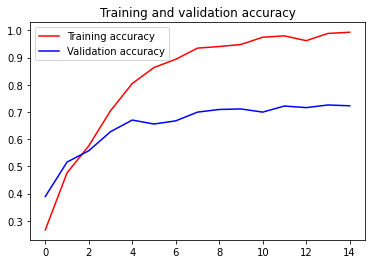

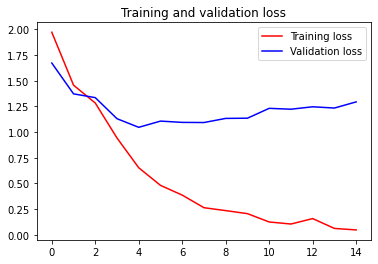

<Figure size 432x288 with 0 Axes>

In [ ]:
print_history(history1)

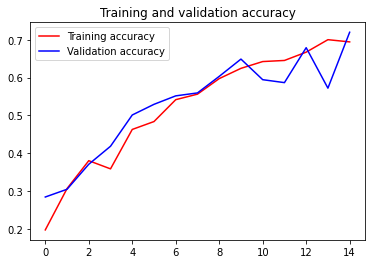

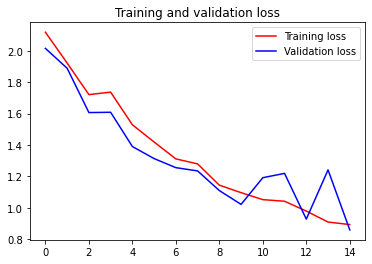

<Figure size 432x288 with 0 Axes>

In [ ]:
print_history(history2)

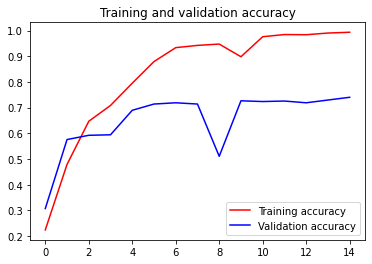

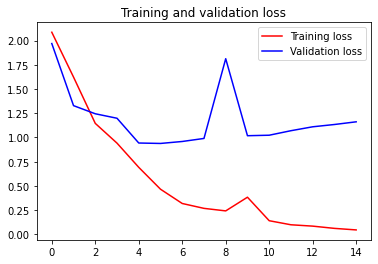

<Figure size 432x288 with 0 Axes>

In [ ]:
print_history(history3)

In [ ]:
### of course we can always look at the performance by label, e.g. using the classification report (like in the BOW notebook)
from sklearn.metrics import classification_report

pred_test_prob = model2.predict(test_padded)
print(pred_test_prob[0])
pred_test =np.argmax(pred_test_prob,axis=1)
print(pred_test[0])
print("----")
print(classification_report(y_test, pred_test, target_names=label_names))

[0.04235559 0.04061202 0.00567512 0.03340151 0.0357483  0.00591849
 0.04135846 0.6872836  0.107647  ]
7
----
               precision    recall  f1-score   support

         Etat       0.56      0.42      0.48        67
       Inland       0.74      0.53      0.62       102
International       0.77      0.77      0.77       151
       Kultur       0.62      0.74      0.67        54
     Panorama       0.62      0.60      0.61       168
        Sport       0.92      0.97      0.95       120
          Web       0.90      0.87      0.88       168
   Wirtschaft       0.56      0.84      0.67       141
 Wissenschaft       0.80      0.35      0.49        57

     accuracy                           0.72      1028
    macro avg       0.72      0.68      0.68      1028
 weighted avg       0.73      0.72      0.71      1028



## Back to our unseen new texts!

* Remeber: We always need the same preprocessing!
* So here: `text_to_sequence` --> `pad_sequence`

In [60]:
new_texts # still in memory, if not, look above

['Der Südbadische Fußballverband (SBFV) hat auf die aktuelle Entwicklung in der Corona-Pandemie reagiert. Der Verbandsvorstand beschloss am Abend, mit dem Spielbetrieb in allen \n             südbadischen Alters- und Spielklassen von der Verbandsliga abwärts vorzeitig in die Winterpause zu gehen.',
 'Vor dem Bund-Länder-Gespräch über weitere Einschränkungen und Verbote werden die Forderungen nach einem harten Lockdown lauter. Der Präsident des Städtetages Baden-Württemberg, \n             Mannheims Oberbürgermeister Peter Kurz (SPD), hält ihn für nötig, wenn sich die Corona-Lage in den kommenden Tagen weiter verschärft.\n             ',
 'Dank einer taktischen Umstellung für die letzten fünf Spielminuten und dem viel zitierten Spielglück haben die Basketballerinnen des USC Freiburg ihren Heimnimbus in dieser Saison gewahrt und sich in der \n             Spitzengruppe der Bundesliga festgekrallt. Am Samstagabend gewannen die Eisvögel im sechsten Spiel in der Unihalle zum sechsten Mal\n 

In [61]:
X_ids = tokenizer.texts_to_sequences(new_texts)

In [62]:
X_ids[0][:20] # first 20 words in first text

[33, 1, 1, 1, 30, 11, 3, 1170, 544, 5, 2, 1, 1, 1832, 33, 1, 6687, 27, 984, 9]

In [63]:
X_padded = pad_sequences(X_ids, maxlen=FIXED_LEN, truncating="post", padding = "post")

In [64]:
X_padded

array([[  33,    1,    1, ...,    0,    0,    0],
       [ 333,   20,  919, ...,    0,    0,    0],
       [2880,   36,    1, ...,    0,    0,    0],
       [6726,    7,    1, ...,    0,    0,    0],
       [ 813,   21,   13, ...,    0,    0,    0]], dtype=int32)

In [ ]:
probs = model3.predict(X_padded) # play around with the 3 model variants
#print(probs)
#print("----")

labels = np.argmax(probs,axis=1)
print(labels)
print("----")

print( [ (l, id_to_label[l]) for l in labels]) # a bit funny sometimes ... :D

[3 7 1 8 3]
----
[(3, 'Kultur'), (7, 'Wirtschaft'), (1, 'Inland'), (8, 'Wissenschaft'), (3, 'Kultur')]
